# Creating Electricity Spot Price predictions for SA, NSW, VIC and QLD with data from amphora.com

In [58]:
#!"./setup-EForecast.sh"
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
import numpy as np
from datetime import datetime
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from joblib import dump, load
from doodahs import doodahs
from doodahs import APIfetch

## Loading data, creating differential features, creating X, and Y data

In [2]:
# load electricity and weather data from the amphora API
params = {'id': '',
        'start_time': datetime(2019,11,9,11),#YYYY,MM,DD,hh,mm
        'end_time': datetime(2019,12,10,5),
        #'filter': ''
        }

e_ids = {'electricity_NSW': 'ecc5263e-83b6-42d6-8852-64beffdf204e',  
        'electricity_QLD': 'ef22fa0f-010c-4ab1-8a28-a8963f838ce9',  
        'electricity_VIC': '3b66da5a-0723-4778-98fc-02d619c70664', 
        'electricity_SA': '89c2e30d-78c8-46ef-b591-140edd84ddb6'}  

electricity_dict = {}
for _ in e_ids:
    params['id'] = e_ids[_]
    banana_temp = APIfetch.fetch_data(params)
    if 'filter' in params:
        del banana_temp['periodType.{}'.format(params['filter'])]
    else:
        del banana_temp['periodType']
    # add the _state suffix to column names:
    banana_temp.columns = [col +'_'+_[_.index('_')+1:] for col in banana_temp.columns]
    banana_temp = banana_temp.sort_index()
    # prevent some weird pandas 'feature' from resampling the df:
    banana_temp = banana_temp.apply(pd.to_numeric,                       errors='coerce')
    electricity_dict[_] = banana_temp.resample('60T').mean()

forecast_dict = {}
for _ in e_ids:
    params['filter'] = 'Forecast'
    params['id'] = e_ids[_]
    banana_temp = APIfetch.fetch_data(params)
    del banana_temp['periodType.Forecast']
    # add the _state suffix to column names:
    banana_temp.columns = [col +'_'+_[_.index('_')+1:] for col in banana_temp.columns]
    banana_temp = banana_temp.sort_index()
    # prevent some weird pandas 'feature' from resampling the df:
    banana_temp = banana_temp.apply(pd.to_numeric,                       errors='coerce')
    forecast_dict[_] = banana_temp.resample('60T').mean()
    del params['filter']
    
w_ids = {'weather_NSW': '11fd3d6a-12e4-4767-9d52-03271b543c66',  
        'weather_QLD': 'a46f461f-f7ee-4cc5-a1e4-569960ea5ed8',  
        'weather_VIC': 'd48ac35f-c658-41c1-909a-f662d6f3a972', 
        'weather_SA': 'f860ba45-9dda-41e0-91aa-73901a323318'}  

weather_dict = {}
for _ in w_ids:
    params['id'] = w_ids[_]
    banana_temp = APIfetch.fetch_data(params)
    if 'filter' in params:
        del banana_temp['description.{}'.format(params['filter'])]
    else:
        del banana_temp['description']
    # add the _state suffix to column names:
    banana_temp.columns = [col +'_'+_[_.index('_')+1:] for col in banana_temp.columns]
    banana_temp = banana_temp.sort_index()
    # prevent some weird pandas 'feature' from resampling the df:
    banana_temp = banana_temp.apply(pd.to_numeric,                       errors='coerce')
    weather_dict[_] = banana_temp.resample('60T').mean()

In [37]:
# join all electricity data
df_elec = electricity_dict['electricity_NSW'].join(electricity_dict['electricity_QLD'])
df_elec = df_elec.join(electricity_dict['electricity_VIC'])
df_elec = df_elec.join(electricity_dict['electricity_SA'])
df_elec = doodahs.create_diffs(df_elec, list(range(len(df_elec.columns))))

# join all forecast data
df_fore = forecast_dict['electricity_NSW'].join(forecast_dict['electricity_QLD'])
df_fore = df_fore.join(forecast_dict['electricity_VIC'])
df_fore = df_fore.join(forecast_dict['electricity_SA'])
df_fore = doodahs.create_diffs(df_fore, list(range(len(df_fore.columns))))

# outer join for all weather data
df_weather = weather_dict['weather_NSW'].join(weather_dict['weather_QLD'])
df_weather = df_weather.join(weather_dict['weather_VIC'])
df_weather = df_weather.join(weather_dict['weather_SA'])
df_weather = doodahs.create_diffs(df_weather, list(range(len(df_weather.columns))))

In [40]:
# re-sort dataset columns and extract test data y
df_elec = df_elec.reindex(sorted(df_elec.columns), axis=1)
y = df_elec.iloc[:,8:12]
for _ in y.columns:
    del df_elec[_]

print('elec shape: ',df_elec.shape)
print('y shape: ',y.shape)

# Create complete dataset of all train variables
df_all = df_weather.join(df_elec)
df_all = df_all.join(df_fore)

print('df_all shape: ',df_all.shape)

elec shape:  (738, 12)
y shape:  (738, 4)
df_all shape:  (699, 76)


In [41]:
# ensure equal shape on both X & Y, so both train and test data share the same timeframe
df_all = df_all.dropna()
y = y[y.index.isin(df_all.index)]
#y = y[(y.index>=df_all.index[0]) & (y.index<=df_all.index[-1])]
assert all(dat in df_all.index for dat in y.index), 'Index differs for df_all and y!'
y.shape

(551, 4)

## Creating Linear, NN and CNN models:

In [42]:
# Calculate correlations to price for slim and nimble multi-linear model:
corr_NSW = (df_all.join(y.iloc[:,0])).corr()
corr_QLD = (df_all.join(y.iloc[:,1])).corr()
corr_SA = (df_all.join(y.iloc[:,2])).corr()
corr_VIC = (df_all.join(y.iloc[:,3])).corr()

In [43]:
##Define data ranges for train, validation, and test set:

# data the model will be trained on (corresponding columns)
train_from = 0
train_to = floor(0.9 * df_all.shape[0])
# data the current model (read: weights) are validated on
valid_from = floor(0.9 * df_all.shape[0])+1
valid_to = floor(0.95 * df_all.shape[0])
# data the final fit will be tested on, to make predictions for the last timesteps
test_from = floor(0.95 * df_all.shape[0])+1
test_to = df_all.shape[0]

In [44]:
# error check:
y.columns

Index(['price_NSW', 'price_QLD', 'price_SA', 'price_VIC'], dtype='object')

### Fitting a multivariate linear model to the top i variables with the highest correlation to 'price_STATE':

In [123]:
# Fitting a multivariate linear model to the top i variables with the highest correlation to 'price_NSW':

state_dict = {'NSW': corr_NSW, 'QLD': corr_QLD, 'VIC': corr_VIC, 'SA': corr_SA}
# df containing the predicted values with correct timestamps:
lin_pred_df = pd.DataFrame(index=df_all.index)

# predict for eacht state according to 
for _ in y.columns:
    # extract state string:
    state = _[_.index('_')+1:]
    # select 8 vars with highest correlation to electricity spot price in state:
    banana = list(state_dict[state][_].sort_values(ascending=False)[1:20].index)
    # create training, validation and validation features:
    training_x = df_all[banana].iloc[train_from:train_to,:]
    training_y = y[[_]].iloc[train_from:train_to,:]
    validation_x = df_all[banana].iloc[valid_from:valid_to,:]
    test_data = y[[_]].iloc[test_from:test_to,:]

    # get the (model, predictions) from the fit:
    lin1, lin1_pred = doodahs.linear_model_predictions(training_x, training_y, validation_x)
    
    # mean absolute error and relative rror:
    mae = doodahs.model_MAE(lin1, lin1_pred, test_data)
    rel = doodahs.rel_error(lin1, lin1_pred, test_data)
    
    # save model to folder ./5_models:
    now = datetime.now()
    dump(lin1, f'./5_models/{state}-lin-model-{now:y%Y-m%m-d%d-h%H-m%M}-error{mae:.1f}.joblib') # load model by using load('./folder/filename')

    # save predictions to df:
    temp_str = ''.join([state,'_linModel-inferred'])
    lin_pred_df[temp_str] = lin1_pred.reshape((len(lin1_pred)))


### Fitting a random forest regressor model to the data for all 'price_STATE':

In [152]:
# Fitting a Random Forest to the entire 60 variable dataset, testing for the influence of the train/test split:

# create predictions df:
RFR_pred_df = pd.DataFrame(index=test_data.index)

# loop over different states:
for _ in y.columns:
    # create state string:
    state = _[_.index('_')+1:]

    # select vars with higher correlation to electricity spot price in state to improve preds:
    banana = list(state_dict[state][_].sort_values(ascending=False)[1:20].index)    
    # create train, test data (validation data is intrinsic due to oob):
    training_x = df_all[banana].iloc[0:valid_to,:]
    training_y = y[[_]].iloc[0:valid_to,:]
    test_x = df_all[banana].iloc[test_from:test_to,:]

    RFR = RandomForestRegressor(n_estimators=1000, random_state=42)
    RFR.fit(training_x, np.ravel(training_y))
    RFR_pred = RFR.predict(test_x)

    # save predictions to predictions dataframe:
    temp_str = ''.join([state,'_RFRModel-inferred'])
    RFR_pred_df[temp_str] = RFR_pred#.reshape((len(lin1_pred)))

    mae = doodahs.model_MAE(RFR,RFR_pred.reshape((len(RFR_pred),1)),test_x)
    rel = doodahs.rel_error(RFR,RFR_pred.reshape((len(RFR_pred),1)),test_x)

    # save model to folder ./5_models:
    now = datetime.now()
    dump(RFR, f'./5_models/{state}-RFR-model-{now:y%Y-m%m-d%d-h%H-m%M}-error{mae:.1f}.joblib') # load model by using load('./folder/filename')

In [154]:
# RFR.feature_importances_
# apple = pd.DataFrame()
# apple['feature'] = [*temp_df.iloc[:,1:16].columns]#,'testfeature']
# apple['importance'] = [*RFR.feature_importances_]
# apple.sort_values(by=['importance'], ascending=False)

#### CNN approach using multiple inputs, one output array:


In [156]:
# split dates into year month day day of week hour, etc for additional features 
df_all = doodahs.split_dates_df(df_all,)

# and this is what the new cols look like
# df_all.iloc[:,-7:-1].head(1)

In [21]:
# data is binned in 2h timesteps thus the following shifts:
y_2h = doodahs.time_shift(y, 1)
y_2h.name = 1
y_6h = doodahs.time_shift(y, 3)
y_6h.name = 3
y_12h = doodahs.time_shift(y, 6)
y_12h.name = 6
y_24h = doodahs.time_shift(y, 12)
y_24h.name = 12
y_timeshift = [y_2h, y_6h, y_12h, y_24h]

Absolutely Rubbish, the accuracy yielded is atrocious.

keras.preprocessing.sequence.TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)


In [172]:
# a bit dense, but it selects all cols containing the '_XXX' substring
# creates a list thereof, unpacks it (* unpacks), then adds others
# unnamde cols:
df_NSW = df_all[[*df_all.columns[['_NSW' in a for a in df_all.columns]],'year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

df_VIC = df_all[[*df_all.columns[['_VIC' in a for a in df_all.columns]],'year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

df_QLD = df_all[[*df_all.columns[['_QLD' in a for a in df_all.columns]],'year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

df_SA = df_all[[*df_all.columns[['_SA' in a for a in df_all.columns]],'year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

In [27]:
import tensorflow as tf
from keras.layers import Input, Dense, concatenate, LeakyReLU
from keras.layers import Reshape
from keras.models import Model
from keras.preprocessing.sequence import TimeseriesGenerator

# first linear NN model:
banana = list(corr_NSW.price_NSW.sort_values(ascending=False)[1:9].index)
training_features = df_all[banana].iloc[0:201,:]
test_features = y[['price_NSW']].iloc[0:201,:]
predict_param = df_all[banana].iloc[202:213,:]

input_size = training_features.shape[1]
inputs = Input(shape=(input_size,))

Dense1 = Dense(1, use_bias=True, kernel_initializer='normal', activation='linear')(inputs)

model_lin_tf = Model(input= inputs, output = Dense1)
model_lin_tf.compile(loss='mse', optimizer='adam')

history = model_lin_tf.fit(training_features, test_features, epochs=10)

doodahs.model_MAE(model_lin_tf, model_lin_tf.predict(predict_param),y[['price_NSW']].iloc[188:199,:], print_result=True)
doodahs.rel_error(model_lin_tf, model_lin_tf.predict(predict_param),y[['price_NSW']].iloc[188:199,:], print_result=True)

# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'])

/Users/markusdollmann/anaconda3/envs/EFORECAST/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
Epoch 1/10
201/201 [==============================] - 0s 2ms/step - loss: 9266.8036
Epoch 2/10
201/201 [==============================] - 0s 37us/step - loss: 856.6569
Epoch 3/10
201/201 [==============================] - 0s 34us/step - loss: 1497.7783
Epoch 4/10
201/201 [==============================] - 0s 37us/step - loss: 1049.4466
Epoch 5/10
201/201 [==============================] - 0s 34us/step - loss: 437.2360
Epoch 6/10
201/201 [==============================] - 0s 41us/step - loss: 605.4468
Epoch 7/10
201/201 [==============================] - 0s 36us/step - loss: 444.1852
Epoch 8/10
201/201 [==============================] - 0s 37us/step - loss: 431.8638
Epoch 9/10
201/201 [==============================] - 0s 34us/step - loss: 402.1540
Epoch 10/10
201/201 [=========

# Random Thoughts

keras.preprocessing.sequence.TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)

length=12? implies one day, neglects these interactions?

In [54]:
model_CNN = doodahs.func_CNN_1(df_QLD, nn_name='model_CNN')
model_CNN.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

/Users/markusdollmann/Desktop/ElectricityForecast/1_modules/doodahs/doodahs.py:267: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="model_CNN", inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


In [65]:
#model_CNN.summary()

In [94]:
import time
batch_size = 24
epochs = 500
start_time = time.time()
NSW = doodahs.reshape_for_CNN(df_NSW)
QLD = doodahs.reshape_for_CNN(df_QLD)
VIC = doodahs.reshape_for_CNN(df_VIC)
SA = doodahs.reshape_for_CNN(df_SA)

# This model optimises for the mse for all four states to be minimal:
history = model_CNN.fit([NSW[0:200,:], QLD[0:200,:], VIC[0:200,:], SA[0:200,:]], y.iloc[0:200,:],
          batch_size=batch_size,
          epochs=epochs,
          verbose=0)

print("--- {} seconds passed ---".format(time.time() - start_time))

# score = model_CNN.evaluate([NSW[201:213,:], QLD[201:213,:], VIC[201:213,:], SA[201:213,:]], y.iloc[201:213,:], verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

predictions = model_CNN.predict([NSW[201:213,:], QLD[201:213,:], VIC[201:213,:], SA[201:213,:]])

--- 37.29268789291382 seconds passed ---


In [95]:
mae, rel = doodahs.MAE_CNN(model_CNN, [NSW[201:213,:], QLD[201:213,:], VIC[201:213,:], SA[201:213,:]], y.iloc[201:213,:])
print('--- MAE of\n {0},\n\nwith a relative error of\n{1} ---'.format(mae, rel))

--- MAE of
 price_NSW    13.244
price_QLD    14.100
price_SA     27.830
price_VIC    19.073
dtype: float64,

with a relative error of
price_NSW     17.875
price_QLD     20.494
price_SA     127.384
price_VIC     23.948
dtype: float64 ---


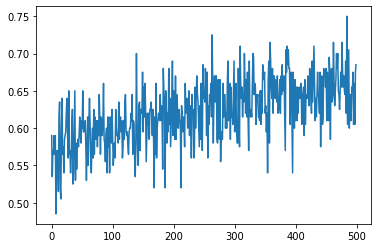

In [100]:
#plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

In [51]:
#reshap = Reshape((Layer.shape[1], 1), input_shape=(X.shape[1], ))(layer)
model.fit_generator()

112

In [ ]:
# the way it is set up, len(TimeseriesGenerator)= (len(data)-length)/batch_size, thus for #epochs>=6 and len(data)=190, length=16 and batch_size=29
# to calculate a good number of batches/epoch, use floor(#samples/batch_size), to avoid seeing datapoints multiple times during a single epoch

# DataGen_NSW = TimeseriesGenerator(df_all, y, 16, sampling_rate=1, stride=1, shuffle=False, reverse=False, batch_size=29)

,price_NSW,price_QLD,price_SA,price_VIC
2019-11-11 15:00:00,73.902058,42.191511,-188.904570,74.399059
2019-11-11 17:00:00,93.971053,86.783147,9.616821,91.430584
2019-11-11 19:00:00,99.080228,106.321299,86.391360,90.160702


In [50]:
arr_ = np.array([[0,1,2,3],['a','b','c','d']])
nrows, ncols = arr_.shape
print(arr_.shape)
arr_.reshape(nrows, ncols, 1)

(2, 4)


array([[['0'],
        ['1'],
        ['2'],
        ['3']],

       [['a'],
        ['b'],
        ['c'],
        ['d']]], dtype='<U21')

,price_NSW,price_QLD,price_SA,price_VIC
2019-11-11 15:00:00,73.902058,42.191511,-188.904570,74.399059
2019-11-11 17:00:00,93.971053,86.783147,9.616821,91.430584
2019-11-11 19:00:00,99.080228,106.321299,86.391360,90.160702


In [35]:
a = a.reshape((a.shape[0], a.shape[1], 1))

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [48]:
y_24h.name = 12

In [51]:
y_24h.name = 12
y_timeshift = [y_2h, y_6h, y_12h, y_24h]

In [52]:
weather_NSW, electricity_NSW = doodahs.import_n_statelabel('NSW')
weather_QLD, electricity_QLD = doodahs.import_n_statelabel('QLD')
weather_VIC, electricity_VIC = doodahs.import_n_statelabel('VIC')
weather_SA, electricity_SA = doodahs.import_n_statelabel('SA')

# join all data state wise
df_NSW = weather_NSW.join(electricity_NSW['scheduledGeneration_NSW'])
df_NSW = doodahs.create_diffs(df_NSW, list(range(len(df_NSW.columns))))
df_QLD = weather_QLD.join(electricity_QLD['scheduledGeneration_QLD'])
df_QLD = doodahs.create_diffs(df_QLD, list(range(len(df_QLD.columns))))
df_VIC = weather_VIC.join(electricity_VIC['scheduledGeneration_VIC'])
df_VIC = doodahs.create_diffs(df_VIC, list(range(len(df_VIC.columns))))
df_SA = weather_SA.join(electricity_SA['scheduledGeneration_SA'])
df_SA = doodahs.create_diffs(df_SA, list(range(len(df_SA.columns))))

y_nn = electricity_NSW.join(electricity_QLD['price_QLD'])
del y_nn['scheduledGeneration_NSW']
y_nn = y_nn.join(electricity_VIC['price_VIC'])
y_nn = y_nn.join(electricity_SA['price_SA'])

print('NSW', df_NSW.shape)   
print('QLD', df_QLD.shape)
print('VIC', df_VIC.shape)   
print('SA', df_SA.shape)       
df_NSW = df_NSW.dropna()
df_QLD = df_QLD.dropna()
df_VIC = df_VIC.dropna()
df_SA = df_SA.dropna()



y_nn = y_nn[(y_nn.index>=df_NSW.index[0])&(y_nn.index<=df_NSW.index[-1])]
assert y_nn.shape[0]==df_NSW.shape[0], 'Different columns lengths detected!'
print('data x shape: ',df_NSW.shape)
print('test y shape: ',y_nn.shape)

[                     price_NSW   price_QLD   price_SA  price_VIC
 2019-11-11 15:00:00  93.971053   86.783147   9.616821  91.430584
 2019-11-11 17:00:00  99.080228  106.321299  86.391360  90.160702
 2019-11-11 19:00:00  66.364615   64.227690  58.054220  61.840291
 2019-11-11 21:00:00  67.524743   64.960000  59.524424  65.541250
 2019-11-11 23:00:00  43.994170   43.253505  37.627617  40.739793
 ...                        ...         ...        ...        ...
 2019-11-27 19:00:00  60.811630   60.686921  66.382507  64.112951
 2019-11-27 21:00:00  48.882500   49.116166  57.240443  52.753398
 2019-11-27 23:00:00  41.057230   39.586084  47.445475  43.007240
 2019-11-28 01:00:00  38.420000   37.423622  41.511857  37.506012
 2019-11-28 03:00:00        NaN         NaN        NaN        NaN
 
 [199 rows x 4 columns],
                      price_NSW  price_QLD   price_SA  price_VIC
 2019-11-11 15:00:00  66.364615  64.227690  58.054220  61.840291
 2019-11-11 17:00:00  67.524743  64.960000  59.5244

In [58]:
electricity_dict['electricity_NSW'].resample('60T').mean()

,price_NSW,scheduledGeneration_NSW
2019-11-09 11:00:00+00:00,77.150094,5466.648813
2019-11-09 12:00:00+00:00,75.228484,5324.231333
2019-11-09 13:00:00+00:00,89.562308,5250.784769
2019-11-09 14:00:00+00:00,74.352310,5052.957333
2019-11-09 15:00:00+00:00,73.655698,4779.852429
...,...,...
2019-12-10 00:00:00+00:00,56.495956,8092.033145
2019-12-10 01:00:00+00:00,63.729611,8556.537543
2019-12-10 02:00:00+00:00,67.493070,8978.043818
2019-12-10 03:00:00+00:00,68.522514,9508.025989


In [167]:
params = {'name': "Test - now also with signals",
        'description': "Can definitely confirm signals extant.",
        'price': 0,
        'file_path': './6_predictions/banana.csv'
        }
APIfetch.upload_series(ananas, params, id_='bab66317-3e8a-4e3f-94b2-aa5fe890dc11')

[{'t': Timestamp('2019-12-16 11:00:00'),
  'banana': 0.0,
  'appl': 1.0,
  'citron': 2.0},
 {'t': Timestamp('2019-12-16 12:00:00'),
  'banana': 3.0,
  'appl': 4.0,
  'citron': 5.0},
 {'t': Timestamp('2019-12-16 13:00:00'),
  'banana': 6.0,
  'appl': 7.0,
  'citron': 8.0},
 {'t': Timestamp('2016-12-16 14:00:00'),
  'banana': 9.0,
  'appl': 10.0,
  'citron': 11.0}]

In [72]:
appler = ''
if not appler:
    print(appler)

In [166]:
ananas = pd.DataFrame([[0,1,2],[3,4,5],[6,7,8],[9,10,11]],index=[datetime(2019,12,16,11,0,0),datetime(2019,12,16,12,0,0,),datetime(2019,12,16,13,0,0),datetime(2016,12,16,14,0,0)], columns=['banana','appl','citron']); ananas.head()

,banana,appl,citron
2019-12-16 11:00:00,0,1,2
2019-12-16 12:00:00,3,4,5
2019-12-16 13:00:00,6,7,8
2016-12-16 14:00:00,9,10,11


In [141]:
signal_list = []
cats = ananas.columns
for row in range(ananas.shape[0]):
    print(row)
    temp_dict = dict(t=ananas.index[row])
    for _ in range(len(cats)):
      temp_dict[cats[_]] = ananas.iloc[row,_]
    signal_list.append(temp_dict)

0
1
2
3


In [142]:
signal_list

[{'t': Timestamp('2019-12-01 00:00:00'), 'banan': 0, 'appl': 1, 'citron': 2},
 {'t': Timestamp('2018-12-01 12:00:00'), 'banan': 3, 'appl': 4, 'citron': 5},
 {'t': Timestamp('2017-12-01 00:00:00'), 'banan': 6, 'appl': 7, 'citron': 8},
 {'t': Timestamp('2016-12-01 00:00:00'), 'banan': 9, 'appl': 10, 'citron': 11}]

In [8]:
electricity_dict

{'electricity_NSW':                            price._NSW  scheduledGeneration._NSW
 2019-11-09 11:00:00+00:00   76.732424               5476.242923
 2019-11-09 12:00:00+00:00   75.001667               5361.238833
 2019-11-09 13:00:00+00:00   89.955000               5252.768500
 2019-11-09 14:00:00+00:00   75.348605               5033.585455
 2019-11-09 15:00:00+00:00   74.153314               4773.684500
 ...                               ...                       ...
 2019-12-10 00:00:00+00:00   55.970478               8155.316572
 2019-12-10 01:00:00+00:00   61.797306               8555.511271
 2019-12-10 02:00:00+00:00   62.821535               8798.406909
 2019-12-10 03:00:00+00:00   58.581257               8985.097994
 2019-12-10 04:00:00+00:00   61.610132               9324.001065
 
 [738 rows x 2 columns],
 'electricity_QLD':                            price._QLD  scheduledGeneration._QLD
 2019-11-09 11:00:00+00:00   54.120000               6604.693000
 2019-11-09 12:00:00+00:0

In [16]:
e = y.copy()
df_all.index.sort_values()

DatetimeIndex(['2019-11-11 02:00:00+00:00', '2019-11-11 03:00:00+00:00',
               '2019-11-11 04:00:00+00:00', '2019-11-11 05:00:00+00:00',
               '2019-11-11 06:00:00+00:00', '2019-11-11 07:00:00+00:00',
               '2019-11-11 08:00:00+00:00', '2019-11-11 09:00:00+00:00',
               '2019-11-11 10:00:00+00:00', '2019-11-11 11:00:00+00:00',
               ...
               '2019-12-09 19:00:00+00:00', '2019-12-09 20:00:00+00:00',
               '2019-12-09 21:00:00+00:00', '2019-12-09 22:00:00+00:00',
               '2019-12-09 23:00:00+00:00', '2019-12-10 00:00:00+00:00',
               '2019-12-10 01:00:00+00:00', '2019-12-10 02:00:00+00:00',
               '2019-12-10 03:00:00+00:00', '2019-12-10 04:00:00+00:00'],
              dtype='datetime64[ns, tzutc()]', length=699, freq='60T')

In [170]:
[*df_all.columns[['_VIC' in a for a in df_all.columns]],'year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']

['temperature_VIC',
 'rainProb_VIC',
 'windSpeed_VIC',
 'windDirection_VIC',
 'cloudCover_VIC',
 'pressure_VIC',
 'd_temperature_VIC',
 'd_rainProb_VIC',
 'd_windSpeed_VIC',
 'd_windDirection_VIC',
 'd_cloudCover_VIC',
 'd_pressure_VIC',
 'd_price_VIC',
 'd_scheduledGeneration_VIC',
 'scheduledGeneration_VIC',
 'price.Forecast_VIC',
 'scheduledGeneration.Forecast_VIC',
 'd_price.Forecast_VIC',
 'd_scheduledGeneration.Forecast_VIC',
 'year',
 'month',
 'day',
 'dayofweek',
 'dayofyear',
 'is_quarter_end',
 'hour']